In [1]:
import networkx as nx
import itertools
import random
from matplotlib import pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import accuracy_score

In [2]:
# BRUTE FORCE

In [3]:

# check if a given set of nodes covers all edges
def covers_all_edges(G, nodes):
    for (u, v) in G.edges:
        if u not in nodes and v not in nodes:
            return False
    return True


In [4]:

# generate all possible subsets of a set
def all_subsets(s):
    subsets = []
    for i in range(len(s) + 1):
        for subset in itertools.combinations(s, i):
            subsets.append(set(subset))
    return subsets


In [5]:

def min_vertex_cover_brute_force(G):
    # initialize minimum vertex cover to be all nodes
    min_vc = set(G.nodes)
    
    # check all possible subsets of vertices
    for nodes in all_subsets(G.nodes):
        if covers_all_edges(G, nodes):
            # update minimum vertex cover if smaller subset is found
            if len(nodes) < len(min_vc):
                min_vc = nodes
                
    return min_vc


In [8]:
# GREEDY ALGORITHM 

In [2]:

def min_vertex_cover_greedy(G):
    G1 = G.copy()
    
    # initialize the set of uncovered edges and vertex cover
    num_of_uncovered_edges = len(G1.edges)
    vertex_cover = set()

    # repeat until all edges are covered
    while num_of_uncovered_edges > 0:
        
        # select a node with a highest degree
        node = max(G1.nodes, key=lambda node: G1.degree[node])
        
        # add the node to the vertex cover and remove all edges covered by the node
        vertex_cover.add(node)
        num_of_covered_edges = len(G1.edges(node))
        num_of_uncovered_edges -= num_of_covered_edges
        
        G1.remove_node(node)
        
    return vertex_cover


In [10]:
# GENETIC ALGORITHM 

In [3]:
class Individual:
    def __init__(self, G):
        self.code = [random.random() < 0.5 for _ in range(len(G.nodes))]
        self.fitness = self.calc_fitness(G)
        self.G = G
        
    def __lt__(self, other):
        return self.fitness < other.fitness
        
        
    # f(x) = ∑︂ xi  +   n · (1 − xi) · ∑︂ (1 − xj) eij
    
    def calc_fitness(self, G):
        n = len(self.code)
        fitness=0
        for i in range(n):
            if self.code[i]:
                fitness+=1
                
            else: 
                for j in range(i, n):
                    if not self.code[j] and G.has_edge(i, j):
                        fitness += n
                           
        return -fitness


In [4]:

def selection(population, tournament_size):
    chosen = random.sample(population, tournament_size)
    winner = max(chosen, key=lambda x: x.fitness)
    return winner


In [5]:
# ravnomerno ukrstanje

def crossover1(parent1, parent2, child1, child2):
    
    for i in range(len(parent1.code)):
        if random.random() < 0.5:
            child1.code[i] = parent1.code[i]
            child2.code[i] = parent2.code[i]
        else:
            child1.code[i] = parent2.code[i]
            child2.code[i] = parent1.code[i]    
    

In [6]:
# dvopoziciono ukrstanje

def crossover2(parent1, parent2, child1, child2):
    pos1, pos2 = random.sample(range(1, len(parent1.code)), 2)
    
    child1.code[:pos1] = parent1.code[:pos1]
    child1.code[pos1:pos2] = parent2.code[pos1:pos2]
    child1.code[pos2:] = parent1.code[pos2:]
    
    child2.code[:pos1] = parent2.code[:pos1]
    child2.code[pos1:pos2] = parent1.code[pos1:pos2]
    child2.code[pos2:] = parent2.code[pos2:]


In [7]:

def mutation(individual, mutation_rate):
    for i in range(len(individual.code)):
        if random.random() < mutation_rate:
            individual.code[i] = not individual.code[i]


In [8]:

def is_cover(individual, G):
    for edge in list(G.edges):
        if not individual.code[edge[0]] and not individual.code[edge[1]]:
            return False
    return True


In [9]:

def vertex_cover(individual, G):
    sol = set()
    
    if is_cover(individual, G) == False:
        sol = set([i for i in range(len(G.nodes)-1)])
    else:
        for i in range(len(individual.code)):
            if individual.code[i]:
                sol.add(i)
                
    return sol


In [10]:

def add_greedy(G):
    greedy_res = min_vertex_cover_greedy(G)
    greedy = Individual(G)
    r = 0
    for i in range(len(G.nodes)):
        if greedy_res.issuperset({i}):
            greedy.code[i]=True
            r+=1
        else:
            greedy.code[i]=False
        
    greedy.fitness=greedy.calc_fitness(G)
    return greedy


In [11]:

def min_vertex_cover_genetic(G, pop_size=100, iters=200, mutation_rate=0.05, elitism_size=10, tournament_size=5, crossover=1):    
    n = len(G.nodes)
    if n<=1:
        return []
    if n==2:
        return [0]
    
    population = [Individual(G) for _ in range(pop_size-1)]
    population.append(add_greedy(G))
    new_population = [Individual(G) for _ in range(pop_size)]
    
    fitnesses = []
    
    for _ in range(iters):
        
        population.sort(key=lambda x: x.fitness, reverse=True)
        new_population[:elitism_size] = population[:elitism_size]
        
        fitnesses.append(population[0].fitness)
        

        for i in range(elitism_size, pop_size, 2):
            
            parent1 = selection(population, tournament_size)
            parent2 = selection(population, tournament_size)
        
            if(crossover==1):
                crossover1(parent1, parent2, new_population[i], new_population[i+1])
            else:
                crossover2(parent1, parent2, new_population[i], new_population[i+1])
            
            mutation(new_population[i], mutation_rate)
            mutation(new_population[i+1], mutation_rate)
                      
            new_population[i].fitness = new_population[i].calc_fitness(G)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(G)
           
        population=new_population
            
            
    plt.plot(np.arange(0, iters, 1), fitnesses)

    population.sort(key=lambda x: x.fitness, reverse=True)
    best_individual = population[0]
    fit = best_individual.fitness
    
    return vertex_cover(best_individual, G)


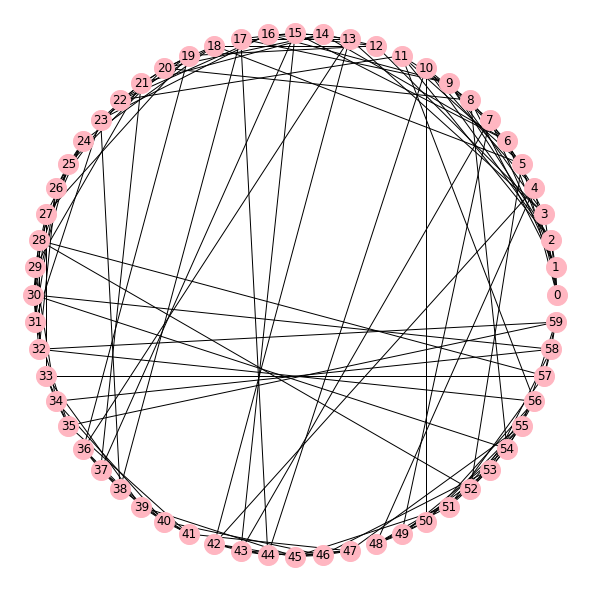

In [12]:
# Berge graph - min vertex cover = 40

G = nx.dodecahedral_graph()

H = nx.complete_graph(3)

GH = nx.Graph()

for u1 in G.nodes():
    for v1 in H.nodes():
        for u2 in G.nodes():
            for v2 in H.nodes():
                if (u1 == u2 and H.has_edge(v1, v2)) or (v1 == v2 and G.has_edge(u1, u2)):
                    GH.add_edge((u1, v1), (u2, v2))


n = len(GH.nodes())
mapping = {i: j for i, j in zip(GH.nodes(), range(n))}
GH = nx.relabel_nodes(GH, mapping)


plt.figure(figsize=(8, 8))
nx.draw(GH, pos=nx.circular_layout(GH),with_labels=True, node_color='lightpink', node_size=400)
plt.show()

{0, 2, 4, 5, 6, 7, 8, 9, 12, 13, 15, 16, 19, 20, 21, 22, 24, 26, 28, 29, 30, 31, 33, 34, 36, 38, 40, 41, 43, 44, 45, 47, 48, 50, 51, 53, 54, 56, 57, 59}
40


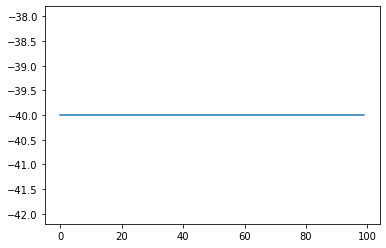

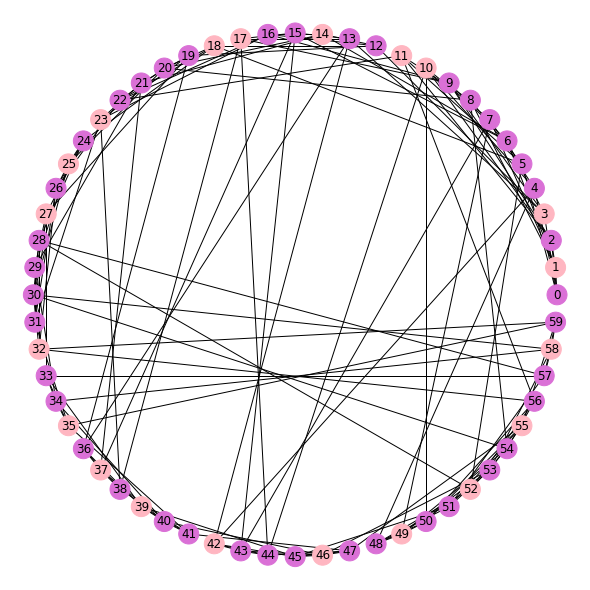

In [93]:
vc = min_vertex_cover_genetic(GH, mutation_rate=0.05, crossover=1, iters=100)
print(vc)
print(len(vc))

colormap=[]
for node in GH.nodes:
    if len(vc.intersection(set([node]))) != 0:
        colormap.append('orchid')
    else:
        colormap.append('lightpink')


plt.figure(figsize=(8, 8))
nx.draw(GH, pos=nx.circular_layout(GH),with_labels=True, node_color=colormap, node_size=400)
plt.show()

In [129]:
C500 = nx.cycle_graph(500)

250 10


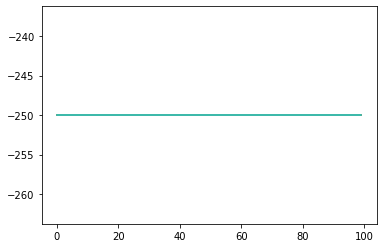

In [130]:
results=[]
for _ in range(10):
    min_vc = min_vertex_cover_genetic(C500, iters=100, crossover=2, mutation_rate=0.01)
    results.append(len(min_vc))
    
results.sort()
for i, j in itertools.groupby(results):
    print(i, len(list(j)))

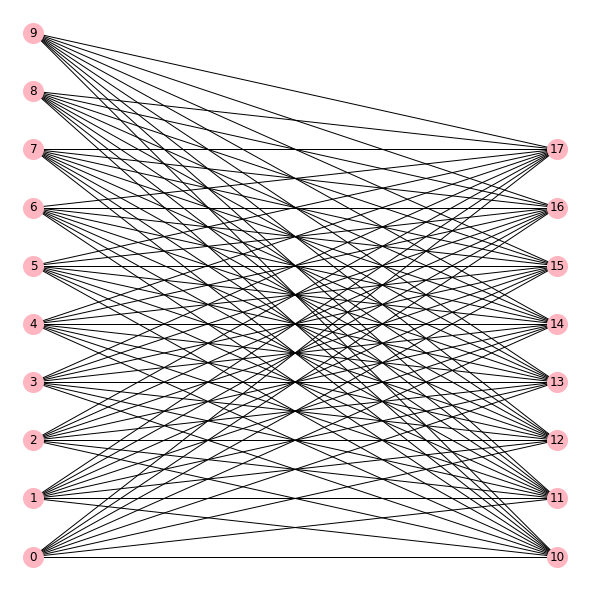

In [173]:

K108 = nx.complete_bipartite_graph(10, 8)

plt.figure(figsize=(8, 8))
nx.draw(K108,with_labels=True, pos = nx.bipartite_layout(G, range(10)), node_color='lightpink', node_size=400)
plt.show()

In [166]:
K100 = nx.complete_bipartite_graph(100, 100)

n = random.sample(K100.nodes(), K100.order())
mapping = dict(zip(K100.nodes(), n))
K100 = nx.relabel_nodes(K100, mapping)

100 20
---------------------------------------


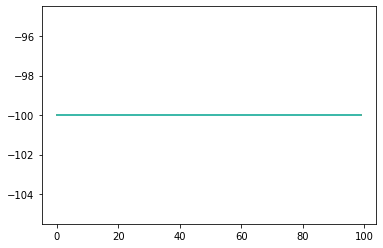

In [167]:
results = []

for _ in range(20):
    min_vc = min_vertex_cover_genetic(K100, iters=100, crossover=1)
    results.append(len(min_vc))
    
results.sort()
for i, j in itertools.groupby(results):
    print(i, len(list(j)))
print("---------------------------------------")


In [83]:
small_graphs=[]
graphs = nx.graph_atlas_g()
small_graphs = random.sample(graphs, 500)

Accuracy: 100.0 %


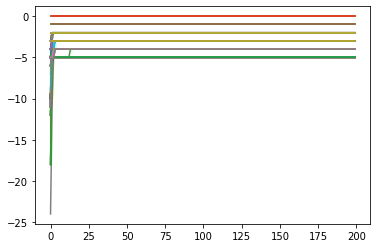

In [95]:

brute_force_results=[]
genetic_results=[]

for g in small_graphs:
    brute_force_results.append(len(min_vertex_cover_brute_force(g)))
    genetic_results.append(len(min_vertex_cover_genetic(g)))

print("Accuracy:", accuracy_score(brute_force_results, genetic_results)*100, "%")

In [99]:

brute_force_results=[]
greedy_results=[]

for g in small_graphs:
    brute_force_results.append(len(min_vertex_cover_brute_force(g)))
    greedy_results.append(len(min_vertex_cover_greedy(g)))

print("Accuracy:", accuracy_score(brute_force_results, greedy_results)*100, "%")

Accuracy: 96.2 %


In [ ]:
# The Witzel Graph

In [16]:
G = nx.Graph()

# Add 30 disjoint cliques with 15 vertices each
for i in range(30):
    nodes = list(range(i*15+1, (i+1)*15+1))
    G.add_nodes_from(nodes)
    G.add_edges_from(nx.complete_graph(nodes).edges())

# Add random edges between pairs of cliques
for i in range(30):
    for j in range(i+1, 30):
        if random.random() < 0.5:
            nodes_i = list(range(i*15+1, (i+1)*15+1))
            nodes_j = list(range(j*15+1, (j+1)*15+1))
            edge = (random.choice(nodes_i), random.choice(nodes_j))
            G.add_edge(*edge)

# Shuffle the labels of the vertices
n = random.sample(G.nodes(), G.order())
n = list(map(lambda x : x-1, n))
mapping = dict(zip(G.nodes(), n))
G = nx.relabel_nodes(G, mapping)

# Print the number of vertices and edges in the graph
print("Number of vertices:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of vertices: 450
Number of edges: 3368


{0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 194, 195, 196, 197, 198, 199, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 226, 227, 228, 229, 230, 231, 2

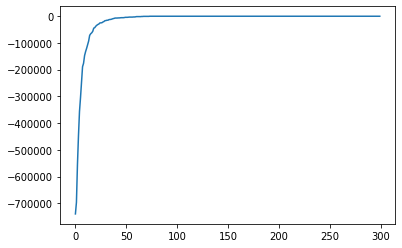

In [70]:
min_vc = min_vertex_cover_genetic(G, iters=300, crossover=2, mutation_rate=0.007, pop_size=150, tournament_size=15)
print(min_vc)
print(len(min_vc))

In [79]:
graph_names = ["brock200-1.mtx", "brock800-4.mtx", 
               "c-fat200-5.mtx", "c-fat500-10.mtx", "hamming10-2.mtx", "hamming10-4.mtx",
               "keller4.mtx", "keller5.mtx", "MANN-a27.mtx",
               "san200-0-7-1.mtx", "sanr400-0-7.mtx"]

In [80]:
graphs_for_testing = []

for graph in graph_names:

    with open("./graphs/"+graph) as file:
        data = file.readlines()
    data = data[2:]
    
    G = nx.Graph()

    for line in data:
        line = line.strip().split()
        u, v = int(line[0])-1, int(line[1])-1
        G.add_edge(u, v)
        
    graphs_for_testing.append((graph, G))
    

Graph:  brock200-1.mtx
------------------------
mutation_rate =  0.1
Best result:  196
---------------------------------------
mutation_rate =  0.05
Best result:  196
---------------------------------------
mutation_rate =  0.01
Best result:  194
---------------------------------------
Graph:  brock800-4.mtx
------------------------
mutation_rate =  0.1
Best result:  793
---------------------------------------
mutation_rate =  0.05
Best result:  793
---------------------------------------
mutation_rate =  0.01
Best result:  793
---------------------------------------
Graph:  c-fat200-5.mtx
------------------------
mutation_rate =  0.1
Best result:  197
---------------------------------------
mutation_rate =  0.05
Best result:  197
---------------------------------------
mutation_rate =  0.01
Best result:  197
---------------------------------------
Graph:  c-fat500-10.mtx
------------------------
mutation_rate =  0.1
Best result:  496
---------------------------------------
mutation_ra

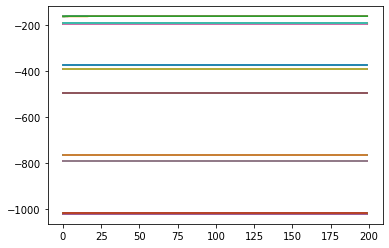

In [89]:
rates = [0.1, 0.05, 0.01]

for g in graphs_for_testing:
    print("Graph: ", g[0])
    print("------------------------")
    
    for i in range(3):
        best = len(g[1].nodes())
        for _ in range(3):
            min_vc = min_vertex_cover_genetic(g[1], pop_size=100, iters=200, crossover=2, mutation_rate=rates[i], elitism_size=4)
            if len(min_vc) < best:
                best = len(min_vc)
            
        print("mutation_rate = ", rates[i])
        print("Best result: ", best)
        print("---------------------------------------")